This is meant to demonstrate the basic functionality of fishlss 

In [16]:
# import all revelant packages
from headers import *

A forecast requires a cosmology and an experiment. Let's first go ahead and define our fidicual cosmology.

In [17]:
params = {
          'output': 'mPk',
          'P_k_max_h/Mpc': 20.,
          'z_pk': '0.0,10',
          'A_s': np.exp(3.040)*1e-10,
          'n_s': 0.96824,
          'h': 0.6770,
          'N_ur': 2.0328,
          'N_ncdm': 1,
          'm_ncdm': 0.06,
          'tau_reio': 0.0568,
          'omega_b': 0.022447,
          'omega_cdm': 0.11923}

cosmo = Class()
cosmo.set(params)
cosmo.compute()

Let's create an experiment that survery galaxies in a redshift range $0.8<z<1.2$. We assume that the number density of the galaxies is constant $n=12 \text{ Mpc}^{-3}$, and that each galaxy's redshift can be measured with uncertainty $\sigma_z/(1+z)=0.01$.

In [18]:
exp = experiment(zmin=0.8,zmax=1.2,n=12.,sigma_z=0.01)

We're now ready to create a forecast.

In [19]:
fishcast = fisherForecast(experiment=exp,cosmo=cosmo,params=params)
# Let's choose the parameters to marginalize over
fishcast.marg_params = np.array(['A_s','n_s','h','omega_b','m_ncdm','omega_cdm'])

fisherForecast objects automatically calculate the fidicual galaxy power spectrum at the central redshift of the experiment. This includes the effects of RSD and redshift errors (if desired). Below is a plot of the fidicual galaxy power spectrum $P_\text{obs}(k,\mu=0)$ at $z=1$

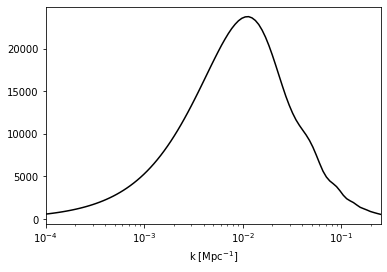

In [20]:
fishcast.pretty_plot(fishcast.k,fishcast.P_fid,xlabel=r'k [Mpc$^{-1}$]')

We can also take derivatives the fidicual power spectrum with respect to any of the cosmological parameters.

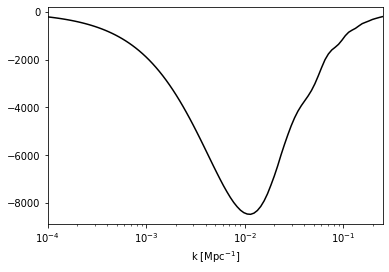

In [21]:
dPdh = fishcast.compute_dPdp(param='h')
fishcast.pretty_plot(fishcast.k,dPdh,xlabel=r'k [Mpc$^{-1}$]')

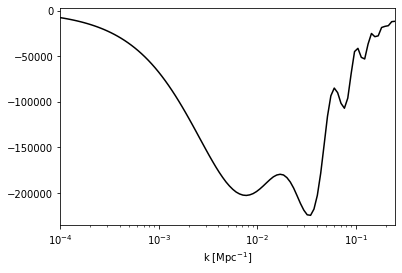

In [26]:
dPdomega_b = fishcast.compute_dPdp(param='omega_b')
fishcast.pretty_plot(fishcast.k,dPdomega_b,xlabel=r'k [Mpc$^{-1}$]')

We can also take one sided derivatives.

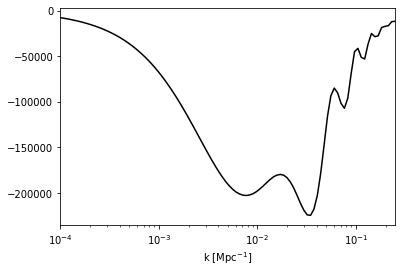

In [27]:
dPdomega_b = fishcast.compute_dPdp(param='omega_b', one_sided=True)
fishcast.pretty_plot(fishcast.k,dPdomega_b,xlabel=r'k [Mpc$^{-1}$]')

Let's see how accurate the derivatives are. Below is a plot of the ratio of the two point derivative to the five point derivative (for $\Omega_b$ and $h$). They agree to within 0.2% of each other

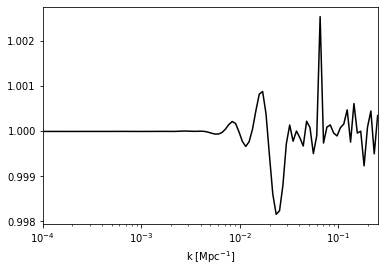

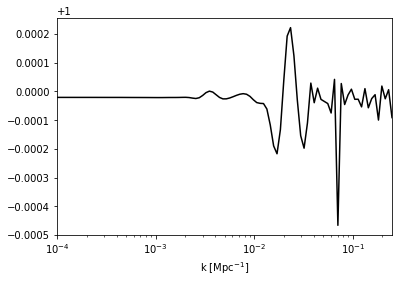

In [29]:
dPdomega_b_five_point = fishcast.compute_dPdp(param='omega_b', five_point=True)
fishcast.pretty_plot(fishcast.k,dPdomega_b/dPdomega_b_five_point,xlabel=r'k [Mpc$^{-1}$]')

dPdh_five_point = fishcast.compute_dPdp(param='h', five_point=True)
fishcast.pretty_plot(fishcast.k,dPdh/dPdh_five_point,xlabel=r'k [Mpc$^{-1}$]')

We can also compute the covariance matrix. Below is a plot of the diagonal elements 

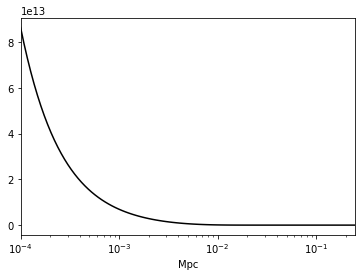

In [9]:
c = fishcast.get_covariance_matrix()
fishcast.pretty_plot(fishcast.k,np.diag(c),xlabel=r'k [Mpc$^{-1}$]')

The Fisher matrix can be computed using

In [10]:
F = fishcast.compute_Fisher_matrix()

And the relative errors on the parameters that we chose to margenalize over can be found using

In [11]:
fishcast.print_marginalized_errors(F=F)

Relative error on A_s: 0.23656754168066316
Relative error on n_s: 0.019005796963668286
Relative error on h: 0.07798453412471543
Relative error on omega_b: 0.05698800077479095
Relative error on m_ncdm: 11.775803739170025
Relative error on omega_cdm: 0.041682763440027915


It's easy to marginalize over a different set of parameters.

In [12]:
fishcast.marg_params = np.array(['A_s','n_s','omega_b','omega_cdm'])
F = fishcast.compute_Fisher_matrix()
fishcast.print_marginalized_errors(F=F)

Relative error on A_s: 0.02559845875699682
Relative error on n_s: 0.009218287926468451
Relative error on omega_b: 0.04831161960460787
Relative error on omega_cdm: 0.00919140505623223
